In [ ]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = ''
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data.dataset import dataset_Krylov, dataset_FD
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.utils import direc_graph_from_linear_system_sparse
from train import train

# Setup experiment

In [688]:
dataset = 'simple'                # 'krylov', 'simple'
grid = 8
N_samples_train = 30
N_samples_test = 5

rhs_train = rhs_test = 'random'           # 'random', 'laplace', [5, 5, 2]
k_train = k_test = 'poisson'           # 'random', 'poisson', [5, 5, 2]
rhs_offset_train = rhs_offset_test = 0
k_offset_train = k_offset_test = 10
lhs_type = 'ilu2'

cg_repeats = 300
if dataset == 'simple': cg_repeats = 1

In [689]:
layer_ = ConstantConv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
loss_type = 'notay'               # Either 'llt' or 'notay'
with_cond = True               # If True will calculate cond during training. Extremly bad scaling (materialization of matrix)
with_final_cond = False         # If True will calculate cond with final L. Also bad scaling

In [690]:
batch_size = 8
lr = 5e-4
epoch_num = 100

In [691]:
# # Uncomment and setup to make steps in learning rate

# steps_per_batch = N_samples_train * cg_repeats // batch_size
# start, stop, step = 45*steps_per_batch, 101*steps_per_batch, 45*steps_per_batch
# decay_size = 1e-1
# lr = optax.piecewise_constant_schedule(
#     lr,
# #     {k: v for k, v in zip([37], [1e-1])}
#     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

# Make dataset

In [692]:
s1 = perf_counter()
if dataset == 'krylov':
    A_train, b_train, u_exact_train, bi_edges_train, res_train, u_app_train = dataset_Krylov(grid, N_samples_train, seed=42, rhs_distr=rhs_train, rhs_offset=rhs_offset_train,
                                                                                             k_distr=k_train, k_offset=k_offset_train, cg_repeats=cg_repeats, lhs_type=lhs_type)
    A_test, b_test, u_exact_test, bi_edges_test, res_test, u_app_test = dataset_Krylov(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
                                                                                       k_distr=k_test, k_offset=k_offset_test, cg_repeats=cg_repeats, lhs_type=lhs_type)
elif dataset == 'simple':
    A_train, b_train, u_exact_train, bi_edges_train = dataset_FD(grid, N_samples_train, seed=42, rhs_distr=rhs_train, rhs_offset=rhs_offset_train,
                                                                 k_distr=k_train, k_offset=k_offset_train, lhs_type=lhs_type)
    A_test, b_test, u_exact_test, bi_edges_test = dataset_FD(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
                                                             k_distr=k_test, k_offset=k_offset_test, lhs_type=lhs_type)
print(perf_counter() - s1)

4.195051997026894


(30, 624) (30, 624) (30, 624)
(344,) (344,) (344,)
0 0


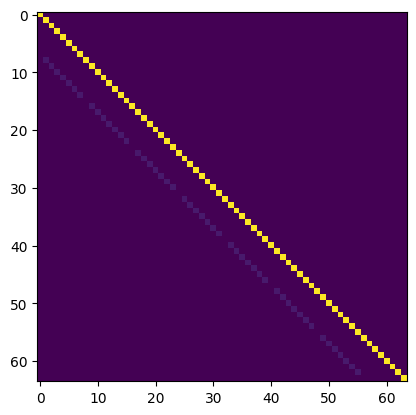

Array([5.0625000e+00, 1.0000000e-15, 5.0625000e+00, 1.0000000e-15,
       5.0625000e+00, 1.0000000e-15, 5.0625000e+00, 1.0000000e-15,
       5.0625000e+00, 1.0000000e-15, 5.0625000e+00, 1.0000000e-15,
       5.0625000e+00, 1.0000000e-15, 5.0625000e+00, 1.0000000e-15,
       3.1640625e-01, 1.0000000e-15, 1.8518518e-31, 5.0625000e+00,
       1.0000000e-15, 3.3750001e-01, 1.0000000e-15, 1.8436214e-31,
       1.0000000e-15, 5.0625000e+00, 1.0000000e-15, 3.3900669e-01,
       1.0000000e-15, 1.8430335e-31, 1.8518518e-31, 1.0000000e-15,
       5.0625000e+00, 1.0000000e-15, 3.3911484e-01, 1.0000000e-15,
       1.8429913e-31, 1.8436214e-31, 1.0000000e-15, 5.0625000e+00,
       1.0000000e-15, 3.3912259e-01, 1.0000000e-15, 1.8429882e-31,
       1.8430335e-31, 1.0000000e-15, 5.0625000e+00, 1.0000000e-15,
       3.3912316e-01, 1.0000000e-15, 1.8429913e-31, 1.0000000e-15,
       5.0625000e+00, 1.0000000e-15, 3.3912319e-01, 1.8429882e-31,
       1.0000000e-15, 5.0625000e+00, 1.0000000e-15, 1.8429881e

In [693]:
from data.utils import direc_graph_from_linear_system_sparse, graph_tril, graph_to_low_tri_mat_sparse
from jax.experimental import sparse as jsparse 

A_train = jsparse.bcoo_sort_indices(A_train)

nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_train, b_train)
print(edges.shape, receivers.shape, senders.shape)
nodes, edges, receivers, senders = nodes[0, ...][None, ...], edges[0, ...], receivers[0, ...], senders[0, ...]
nodes, edges, receivers, senders = graph_tril(nodes, edges, receivers, senders)
print(edges.shape, receivers.shape, senders.shape)

# abc_tril = vmap(graph_to_low_tri_mat_sparse, in_axes=(0, 0, 0, 0), out_axes=(0))(nodes[None, ...], edges[None, ...], receivers[None, ...], senders[None, ...])
abc_tril = graph_to_low_tri_mat_sparse(nodes, edges, receivers, senders)
# abc_tril.data = abc_tril.data * 0 + 1
for i in range(1):
#     abc_tril.data = abc_tril.data * 0 + 1
#     abc_tril.data = abc_tril.data.at[i].set(.5)
    plt.imshow(abc_tril.todense())
    print(senders[i], receivers[i])
    plt.show();
abc_tril.data

In [699]:
import jax

@partial(jit, static_argnums=(2))
def jspsolve_triangular_efficient(A, b, lower):
    '''A must be a lower/upper triangular matrix.
       It should be "valid": not singular (have no zeros on diagonal, no empty rows, etc.)'''
    A = A.sort_indices()
    Aval, bval = A.data, b
    Arows, Acols = A.indices[:, 0], A.indices[:, 1]
    x = jnp.zeros_like(bval)    
    
    diag_edge_indx = jnp.diff(jnp.hstack([Arows[:, None], Acols[:, None]]))
    diag_edge_indx = jnp.where(diag_edge_indx == 0, 1, 0)
    diag_edge_indx = jnp.nonzero(diag_edge_indx, size=nodes.shape[1], fill_value=jnp.nan)[0].astype(jnp.int32)

    if lower:
        xs_ = jnp.hstack([
            jnp.arange(x.shape[0])[:, None],
            diag_edge_indx[:, None]
        ])
    else:
        xs_ = jnp.hstack([
            jnp.arange(x.shape[0]-1, -1, -1)[:, None],
            diag_edge_indx[::-1][:, None]
        ])

#     for i, diag_ind in xs_:
#         row_ind = jnp.where(Arows == i, 1, 0)
#         x_i = x.at[jnp.where(row_ind, Acols, Acols.shape[0])].get(mode='fill', fill_value=0)
#         A_i = Aval.at[jnp.where(Arows == i, jnp.arange(Aval.shape[0]), Arows.shape[0])].get(mode='fill', fill_value=0)
        
#         c = jnp.sum(A_i * x_i)
#         x = x.at[i].set(bval[i] - c)
#         x = x.at[i].divide(Aval[diag_ind] + 1e-9)
    def f_(carry, k):
        i, diag_ind = k
        Aval_, Arows_, Acols_, bval_, x_ = carry
        row_ind = jnp.where(Arows_ == i, 1, 0)
        
        x_i = x_.at[jnp.where(row_ind, Acols_, Acols_.shape[0])].get(mode='fill', fill_value=0)
        A_i = Aval_.at[jnp.where(Arows_ == i, jnp.arange(Aval_.shape[0]), Arows_.shape[0])].get(mode='fill', fill_value=0)

        c = jnp.sum(A_i * x_i)
        x_ = x_.at[i].set(bval_[i] - c)
        x_ = x_.at[i].divide(Aval_[diag_ind] + 1e-9)
        return (Aval_, Arows_, Acols_, bval_, x_), None
    
    carry_ = (Aval, Arows, Acols, bval, x)
    (_, _, _, _, x), _ = jax.lax.scan(f_, carry_, xs_)
    return x

In [700]:
bn = jsparse.sparsify(lambda A: A.T)(abc_tril)#.todense()
l_ = False
arr = abc_tril if l_ else bn

x1 = jspsolve_triangular_efficient(arr, b_train[0, :], lower=l_)
# display(x1)
nodes[0, :] - arr @ x1

Array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -2.9802322e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.4901161e-08,
        0.0000000e+00,  0.0000000e+00,  1.4901161e-08,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -5.9604645e-08,
        2.9802322e-08,  0.0000000e+00, -7.4505806e-09,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        2.9802322e-08,  0.0000000e+00, -5.9604645e-08,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.1920929e-07,
        0.0000000e+00,  1.4901161e-08,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  2.9802322e-08,  0.0000000e+00,  2.9802322e-08,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  7.4505806e-09, -2.9802322e-08,  0.0000000e+00,
      

In [696]:
from scipy.sparse.linalg import spsolve_triangular
from scipy.sparse import csr_matrix
bbb_ = csr_matrix(np.asarray(arr.todense()))
x2 = spsolve_triangular(bbb_, np.asarray(b_train[0, :]), lower=l_)
# display(x2)
nodes[0, :] - bbb_ @ x2

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [697]:
display(jnp.abs(x1-x2).max())
bbb_.nnz, abc_tril.nse

Array(1.4901161e-08, dtype=float32)

(344, 344)

In [698]:
print(jnp.abs(x1 - x2).max(), end='\n--------------\n')
for x_i in jnp.abs(x1 - x2):
    print(x_i)

1.4901161e-08
--------------
0.0
0.0
0.0
0.0
7.450581e-09
1.8626451e-09
7.450581e-09
0.0
0.0
0.0
0.0
3.7252903e-09
0.0
0.0
1.8626451e-09
0.0
0.0
0.0
0.0
0.0
7.450581e-09
0.0
0.0
0.0
0.0
1.4901161e-08
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.656613e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.7252903e-09
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4901161e-08
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Train model

In [ ]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),    
    update_node_fn = FullyConnectedNet(features=[32, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

In [ ]:
# data = (X_train, X_test, y_train, y_test)
if dataset == 'krylov':
    data = (
        [A_train, b_train, bi_edges_train, u_exact_train, res_train, u_app_train],
        [A_test, b_test, bi_edges_test, u_exact_test, res_test, u_app_test],
        jnp.array([1]), jnp.array([1])
    )
elif dataset == 'simple':
    data = (
        [A_train, b_train, bi_edges_train, u_exact_train],
        [A_test, b_test, bi_edges_test, u_exact_test],
        jnp.array([1]), jnp.array([1])
    )
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size
}

### Pre-train with $LL^T$ loss 

In [ ]:
# batch_size = 4
# lr = 1e-2

# # steps_per_batch = N_samples_train // batch_size
# # start, stop, step = 20*steps_per_batch, 101*steps_per_batch, 20*steps_per_batch
# # decay_size = 1e-1
# # lr = optax.piecewise_constant_schedule(
# #     lr,
# # #     {k: v for k, v in zip([37], [1e-1])}
# #     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# # )
# pretrain_train_config = {
#     'optimizer': optax.adam,
#     'lr': lr,
#     'optim_params': {},#{'weight_decay': 1e-8}, 
#     'epoch_num': 150,
#     'batch_size': batch_size
# }
# model, losses_pre = train(model, data, pretrain_train_config, loss_name='llt', with_cond=True)

-----

In [ ]:
s = perf_counter()
model, losses = train(model, data, train_config, loss_name=loss_type, with_cond=with_cond, repeat_step=cg_repeats)
dt = perf_counter() - s

In [ ]:
dt

In [ ]:
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(*direc_graph_from_linear_system_sparse(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...])[:-1], bi_edges_test[::cg_repeats, ...])
del model, data, A_train, b_train, u_exact_train, bi_edges_train
if dataset == 'krylov': del res_train, res_test, u_app_train, u_app_test
clear_caches()

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))

# No pre-train
axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')

# # With pre-train
# axes[0].plot(range(len(losses_pre[0])), losses_pre[1], label='Test')
# axes[0].plot(range(len(losses_pre[0])), losses_pre[0], label='Train')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[1], label='Test')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[0], label='Train')

axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Notay loss');
axes[0].grid();


if with_cond:
    # No pre-train
    axes[1].plot(range(len(losses[0])), losses[2], label='Test real cond P^(-1)A')

    # With pre-train
    # axes[1].plot(range(len(losses_pre[0])), losses_pre[2], label='Test')
    # axes[1].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[2], label='Test')

    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Condition number of $LL^T$')
    axes[1].grid();


# axes[0].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# axes[1].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# for vl in [28]:#[13, 17, 22, 25, 29, 39, 59, 79]:
#     axes[0].axvline(vl, 0, 1e11, linestyle='--', c='k')
#     axes[1].axvline(vl, 0, 1e11, linestyle='--', c='k')
plt.tight_layout()


if with_cond: 
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
    print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')
else:
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
if with_final_cond:
    cond_A, cond_LLT = jit(asses_cond)(A_test[::cg_repeats, ...], L)
    print(f'\nTest lhs A cond: {cond_A:.0f}, test P^(-1)A cond: {cond_LLT:.0f}')

# Apply model to CG

In [ ]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...], N_iter=300, prec_func=None, seed=42)

In [ ]:
# Prec = LL^T
prec = partial(llt_prec, L=L)

X_LLT, R_LLT = ConjGrad(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...], N_iter=300, prec_func=prec, seed=42)

In [ ]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="Notay loss")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

# plt.ylim([1e-15, 1e0]);
# plt.vlines([10, 20], [1e-15]*2, [100]*2, linestyle='--', color='k')

res_I_dict = iter_per_residual(R_I)
res_LLT_dict = iter_per_residual(R_LLT)
print('        Simple CG:', res_I_dict)
print('Preconditioned CG:', res_LLT_dict)

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()